# Build MNIST-1D

In [3]:
# Run this if you're in a Colab
!git clone https://github.com/greydanus/mnist1d

Cloning into 'mnist1d'...
remote: Enumerating objects: 148, done.
remote: Counting objects: 100% (148/148), done.
remote: Compressing objects: 100% (122/122), done.
remote: Total 148 (delta 49), reused 124 (delta 26), pack-reused 0
Receiving objects: 100% (148/148), 6.47 MiB | 15.21 MiB/s, done.
Resolving deltas: 100% (49/49), done.


In [120]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import time, copy
import torch
import torch.nn.functional as F
import random
from scipy.ndimage.filters import gaussian_filter
from scipy.interpolate import interp1d
import tensorflow as tf

from mnist1d.data import get_templates, get_dataset_args, get_dataset
from mnist1d.train import get_model_args, train_model
from mnist1d.models import ConvBase, GRUBase, MLPBase, LinearBase
from mnist1d.utils import set_seed, plot_signals, ObjectView, from_pickle

from google.colab import drive
drive.mount('/content/gdrive')
project_dir = "/content/gdrive/My Drive/Research/metalearn_afunc/"

PROJECT_DIR = './'

class ObjectView(object):
    def __init__(self, d): self.__dict__ = d

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Attaching GPU if any

In [2]:
# Try attaching to GPU
DEVICE = str(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
print('Using:', DEVICE) 

Using: cpu


## Download the MNIST-1D dataset

In [4]:
# args = mnist1d.get_dataset_args()
# args.num_samples = 10000
# data = mnist1d.get_dataset(args=args, download=False, regenerate=True)  # need to regenerate, since baseline dataset only has 4000/1000 samples
import sys ; sys.path.append('..')  # useful if you're running locally
import mnist1d

args = mnist1d.get_dataset_args()
data = mnist1d.get_dataset(args, path='./mnist1d_data.pkl', download=True) # This is the default setting

print("Examples in training set: {}".format(len(data['y'])))
print("Examples in test set: {}".format(len(data['y_test'])))

print("Length of each input: {}".format(data['x'].shape[-1]))

print("Number of classes: {}".format(len(data['templates']['y'])))

train_data_size = len(data['x'])
test_data_size = len(data['x_test'])

print(train_data_size)
print(test_data_size)

File already exists. Skipping download.
Successfully loaded data from ./mnist1d_data.pkl
Examples in training set: 8000
Examples in test set: 2000
Length of each input: 40
Number of classes: 10
8000
2000


In [5]:
print(list(data))

['x', 'x_test', 'y', 'y_test', 't', 'templates']


# TESTER

In [45]:
from numpy.random.mtrand import rand
  
# generate a random subset of indices for the training and test data
random_num_generator = np.random.RandomState(args.seed)

# Create a list of random seeds
seeds_list = np.random.randint(4000, size = 4)

seeds_list

array([1296, 1329, 3876, 1233])

## Initialize Variables

In [6]:
train_data_size = len(data['x'])
test_data_size = len(data['x_test'])

## Initialize the hyperparameters

In [7]:
t = 4000
m = int( 0.7 * train_data_size)

## Sample t random subsets of [n] of size m: I_1, I_2, I_3...

In [8]:
from numpy.random.mtrand import rand
# generate a random subset of indices for the training and test data
random_num_generator = np.random.RandomState(15)

# Generate subset of random indices of size m from (0,train_data_size) without replacement.
random_indices = np.random.choice(train_data_size, size = m, replace = False)

print(len(random_indices))

train_images = data["x"][random_indices]
print(np.shape(train_images))

5600
(5600, 40)


In [111]:
def create_subsets(dataset, t_iterations, m_ratio):
  '''Creates a subset of a dataset with given ratio. Parameter t_iterations - number of iterations / subsets. m_ratio - size of the subset.'''
  # Lists that will contain subsets of random samples
  # train_random_samples = []
  # test_random_samples = []

  # Create a subset structure with the same testing data
  subset = {'x':None,'y':None, 'x_test':dataset['x_test'],'y_test':dataset['y_test'],'indices':None}

  # Create a list of subsets
  list_of_subsets = []

  # create a random number generator
  random_num_generator = np.random.RandomState(args.seed)

  # Create a list of random seeds
  seeds_list = np.random.randint(t_iterations, size = t_iterations)
  
  for i in range(t_iterations):
    
    # create a random number generator
    random_num_generator = np.random.RandomState(seeds_list[i])

    # Generate subset of random indices of size m from (0,train_data_size) without replacement.
    random_indices = random_num_generator.choice(train_data_size, size = m, replace = False)

    # Save the random indices in the subset structure
    subset['indices'] = random_indices
    
    # Create a subset of training images and then of testing images / labels
    subset['x'] = dataset["x"][random_indices]
    subset['y'] = dataset["y"][random_indices]

    # Append the subset to the lists of subsets
    list_of_subsets.append(subset)

  return list_of_subsets


In [70]:
get_model_args(as_dict=True)

{'batch_size': 100,
 'checkpoint_every': 1000,
 'device': 'cpu',
 'eval_every': 250,
 'hidden_size': 256,
 'input_size': 40,
 'learning_rate': 0.01,
 'output_size': 10,
 'print_every': 1000,
 'seed': 42,
 'total_steps': 8000,
 'weight_decay': 0}

## Create all necessary subsets

In [112]:
subsets = create_subsets(data,t,m)

## Algorithm A

In [113]:
# get the model info
args = get_model_args()

# list to keep all the models
list_of_mlp_models = []
list_of_ConvBase_models = []

# list ot keep all the training results
trained_mlp_model_results = []
trained_ConvBase_model_results = []

def train_MLPBase_models(t,subsets,args):
  '''Creates t MLPBase models. Parameter t - number of trials.'''
  # Create and traing t models
  for k in range(t):
    # set the seed
    set_seed(k)

    # create a model
    model = MLPBase(args.input_size, args.output_size)
    
    # append model to the list of models
    list_of_mlp_models.append(model)

    # define the subset of data you wan to use
    data_subset = subsets[k]

    # train the model
    mlp_training_results = train_model(data_subset, model, args)

    # append the results of the model
    trained_mlp_model_results.append(mlp_training_results)

  return list_of_mlp_models, trained_mlp_model_results

def train_ConvBase_models(t,subsets,args):
  '''Creates t ConvBase models. Parameter t - number of trials.'''
  # Create and traing t models
  for k in range(t):
    # set the seed
    #set_seed(args.seed)
    set_seed(k)

    # create a model
    model = ConvBase(output_size=args.output_size)
    
    # append model to the list of models
    list_of_ConvBase_models.append(model)

    # define the subset of data you wan to use
    data_subset = subsets[k]

    # train the model
    ConvBase_training_results = train_model(data_subset, model, args)

    # append the results of the model
    trained_ConvBase_model_results.append(ConvBase_training_results)

  return list_of_ConvBase_models, trained_ConvBase_model_results



## Train the models on the subsets

In [192]:
# MLP base
list_of_mlp_models, trained_mlp_model_results = train_MLPBase_models(15,subsets,args)

# ConvBase
list_of_ConvBase_models, trained_ConvBase_model_results = train_ConvBase_models(12,subsets,args)

Initialized MLPBase model with 15210 parameters
step 1000, dt 1.35s, train_loss 3.476e-01, test_loss 1.225e+00, train_acc 89.5, test_acc 65.8
step 2000, dt 1.52s, train_loss 5.535e-02, test_loss 1.891e+00, train_acc 95.1, test_acc 67.5
step 3000, dt 1.50s, train_loss 3.627e-02, test_loss 2.393e+00, train_acc 97.5, test_acc 69.1
step 4000, dt 1.43s, train_loss 3.986e-02, test_loss 2.928e+00, train_acc 95.9, test_acc 68.3
step 5000, dt 1.60s, train_loss 6.464e-02, test_loss 3.416e+00, train_acc 98.9, test_acc 68.3
step 6000, dt 1.67s, train_loss 1.791e-01, test_loss 3.817e+00, train_acc 98.3, test_acc 68.1
step 7000, dt 1.77s, train_loss 4.729e-02, test_loss 4.617e+00, train_acc 98.2, test_acc 68.0
step 8000, dt 1.59s, train_loss 1.003e-01, test_loss 4.906e+00, train_acc 97.5, test_acc 67.9
Initialized MLPBase model with 15210 parameters
step 1000, dt 1.38s, train_loss 3.679e-01, test_loss 1.495e+00, train_acc 82.4, test_acc 62.4
step 2000, dt 1.34s, train_loss 1.481e-01, test_loss 2.175

In [159]:
np.shape(trained_ConvBase_model_results)

# batch index  -  test losses - index of a sample
trained_ConvBase_model_results[0]['test_acc'][0]

# trainset_mask = np.vstack([ret[0] for ret in trained_mlp_model_results])
# inv_mask = np.logical_not(trainset_mask)
# trainset_correctness = np.vstack([ret[1] for ret in trained_mlp_model_results])
# testset_correctness = np.vstack([ret[2] for ret in trained_mlp_model_results])

# print(f'Avg test acc = {np.mean(testset_correctness):.4f}')
# np.shape(subsets[0]['x'])

# len(random_indices)

# trainset_mask = np.zeros(train_data_size, dtype=np.bool)
# trainset_mask[random_indices] = True

# trainset_mask

# Create a list of masks that will mark what instances are used in each subset
trainset_mask = np.zeros(train_data_size, dtype=np.bool)
# trainset_mask[subsets[0]['indices']] = True
# trainset_mask[subsets[0]['indices']] 
# subsets[0]['indices']
list_of_mlp_models[0]

data_tensor = tf.convert_to_tensor(subsets[0]['x'])
data_tensor1 = torch.from_numpy(subsets[0]['x'])
data_tensor2 = torch.from_numpy(subsets[0]['y'])

# for i in subsets[0]['y']:
#   subsets[0]['y']
# floats[i] = float(i) for i  in subsets[0]['y'][i] if type(subsets[0]['y'][i]) == Double
x_train, x_test = torch.Tensor(subsets[0]['x']), torch.Tensor(subsets[0]['x_test'])
y_train, y_test = torch.LongTensor(subsets[0]['y']), torch.LongTensor(subsets[0]['y_test'])
  
print(np.shape(x_train[0]))

# list_of_mlp_models[0] = list_of_mlp_models[0].to(args.device)
trainset_correctness = train.accuracy(list_of_mlp_models[0], x_train,y_train)

trainset_correctness

len(list_of_mlp_models)

torch.Size([40])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


4

# Memorization

In [197]:
# tqdm - package used to shoe a progress bar when loops executing
# tqdm - "progress" in arabic and obriviation for  "Te Quiero DeMaciado" in Spanish (I love you so much)
from tqdm import tqdm 
from mnist1d import train

def estimate_mem_infl(list_of_models, model_results, subset_index, subsets):
  '''Computes memorization and influence estimates. Parameters: list of all models and their results as well as the subset index in the list of the subsets.'''

  # Create a list of masks that will mark what instances are used in each subset
  trainset_mask = np.zeros(train_data_size, dtype=np.bool)
  trainset_mask[subsets[subset_index]['indices']]  = True

  # An inverse of the mask (instances that are not used in this subset)
  inv_mask = np.logical_not(trainset_mask)

  # Convert splits into the proper forms
  x_train, x_test = torch.Tensor(subsets[subset_index]['x']), torch.Tensor(subsets[subset_index]['x_test'])
  y_train, y_test = torch.LongTensor(subsets[subset_index]['y']), torch.LongTensor(subsets[subset_index]['y_test'])

  # Accuracy of the training set
  # trainset_correctness = train.accuracy(list_of_models[subset_index], subsets[subset_index]['x'],subsets[subset_index]['y'])
  trainset_correctness = train.accuracy(list_of_models[subset_index], x_train,y_train)

  # Accuracy of the testing set
  # testset_correctness = train.accuracy(list_of_models[subset_index], subsets[subset_index]['x_test'],subsets[subset_index]['y_test'])
  testset_correctness = train.accuracy(list_of_models[subset_index], x_test,y_test)

  # memorization estimate
  def memorization_estimate(x, mask, axis=0, esp=1e-10):
    return (np.sum(x * mask, axis=axis) / np.maximum(np.sum(mask, axis=axis), esp)).astype(np.float32)

  #influence estimate
  # def influence_estimate(x, mask, esp=1e-10):
  #   x = x.T.astype(np.float32)
  #   return (np.matmul(x, mask) / np.maximum(np.sum(mask, axis=0, keepdims=True), esp)).astype(np.float32)

  mem_est = memorization_estimate(trainset_correctness, trainset_mask) - memorization_estimate(trainset_correctness, inv_mask)
  # infl_est = influence_estimate(testset_correctness, trainset_mask) - influence_estimate(testset_correctness, inv_mask)

  # return dict(memorization=mem_est, influence=infl_est)
  return dict(memorization=mem_est)

estimates = []

for subset in tqdm(range(15)):
  print()
  print(subset)
  estimates.append(estimate_mem_infl(list_of_mlp_models, trained_mlp_model_results, subset,subsets ))
# estimates = estimate_mem_infl(list_of_mlp_models, trained_mlp_model_results, 1,subsets )


  0%|          | 0/15 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.
 13%|█▎        | 2/15 [00:00<00:00, 19.72it/s]


0

1

2

3


 47%|████▋     | 7/15 [00:00<00:00, 20.72it/s]


4

5

6

7

8

9


100%|██████████| 15/15 [00:00<00:00, 25.70it/s]


10

11

12

13

14


In [200]:
estimates

[{'memorization': 0.0},
 {'memorization': 0.0},
 {'memorization': 0.0},
 {'memorization': 0.0},
 {'memorization': 0.0},
 {'memorization': 0.0},
 {'memorization': 0.0},
 {'memorization': 0.0},
 {'memorization': 0.0},
 {'memorization': 0.0},
 {'memorization': 0.0},
 {'memorization': 0.0},
 {'memorization': 0.0},
 {'memorization': 0.0},
 {'memorization': 0.0}]

# Histogram of Memorization 

[1]


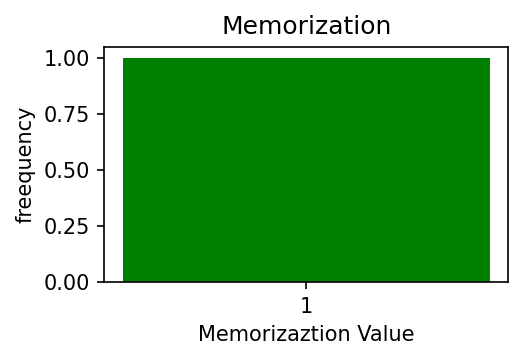

In [218]:
fig = plt.figure(figsize=(3.5, 2.5), dpi=150)
# err_ixs = np.where(guesses!=trues)
# err_classes = trues[err_ixs]

# Count occurrence of element '3' in numpy array
frequencies = {}
for element in estimates:
  if element not in list(frequencies.keys()):
    frequencies[str(element)] = 1
  else:
    frequencies[str(element)] += 1
    
# x = list(frequencies.keys())
y = list(frequencies.values())
x_ = [i for i, _ in enumerate(frequencies)]

print(y)

values = [frequencies[i] for i in (frequencies)]

plt.bar(x, y, color='green')
plt.xlabel("Memorizaztion Value")
plt.ylabel("freequency")
plt.title("Memorization")

plt.xticks(x, y)

plt.tight_layout() ; plt.show()

# Showing Examples

In [105]:
def show_examples(estimates, n_show=10):
  def show_image(ax, image, vmin=None, vmax=None, title=None):
    if image.ndim == 3 and image.shape[2] == 1:
      image = image.reshape((image.shape[0], image.shape[1]))
    ax.axis('off')
    ax.imshow(image, cmap='gray', vmin=vmin, vmax=vmax)
    if title is not None:
      ax.set_title(title, fontsize='x-small')

  n_show = 10
  n_context1 = 4
  n_context2 = 5

  fig, axs = plt.subplots(nrows=n_show, ncols=n_context1+n_context2+1,
                          figsize=(n_context1+n_context2+1, n_show))
  idx_sorted = np.argsort(np.max(estimates['influence'], axis=1))[::-1]
  for i in range(n_show):
    # show test example
    idx_tt = idx_sorted[i]
    label_tt = data['test_int_labels'][idx_tt]
    show_image(axs[i, 0], data['test_byte_images'][idx_tt], 
               title=f'test,L={label_tt}')

    def _show_contexts(idx_list, ax_offset):
      for j, idx_tr in enumerate(idx_list):
        label_tr = data['train_int_labels'][idx_tr]
        infl = estimates['influence'][idx_tt, idx_tr]
        show_image(axs[i, j+ax_offset], data['train_byte_images'][idx_tr],
                   title=f'tr,L={label_tr},infl={infl:.3f}')

    # show training examples with highest influence
    idx_sorted_tr = np.argsort(estimates['influence'][idx_tt])[::-1]
    _show_contexts(idx_sorted_tr[:n_context1], 1)

    # show random training examples from the same class
    idx_class = np.nonzero(data['train_int_labels'] == label_tt)[0]
    idx_random = np.random.choice(idx_class, size=n_context2, replace=False)
    _show_contexts(idx_random, n_context1 + 1)

  plt.tight_layout()
  plt.savefig('mnist-examples.pdf', bbox_inches='tight')